# Gemerate fake


In [16]:
from dataclasses import dataclass
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm

## Configuration

In [17]:
@dataclass
class Config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = "demo_SJTU"
    diffusion_steps = 1000
    learn_rate = 1e-4
    image_size = 64
    num_samples = 4  # Number of samples to generate
    load_from_checkpoint = True  # Start training from checkpoint if one exists for the given model name

## Utils

In [18]:
def save_image_batch(image_batch, filename):
    """
    Save a batch of image tensors to disk as a single grid image

    Parameters:
    - image_batch: batch of unnormalized image tensors with shape (batch_size, channels, height, width)
    - filename: File path and name to save image without extension 
    """
    # Normalize images to [0, 1]
    image_batch = torch.clamp(image_batch * 0.5 + 0.5, 0, 1)

    # Create image grid and convert to PIL image
    image_grid = make_grid(image_batch)
    image_grid = np.transpose(image_grid.cpu().numpy(), (1, 2, 0))
    pil_image = Image.fromarray((image_grid * 255).astype(np.uint8))

    # Split the path into directory and filename
    path = f"{filename}.png"
    directory, filename = os.path.split(path)

    # Create the directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save image to disk
    pil_image.save(path)


def save_checkpoint(state, filename):
    # Split the path into directory and filename
    path = f"{filename}.pt"
    directory, filename = os.path.split(path)

    # Create the directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save checkpoint state
    torch.save(state, path)


def load_checkpoint(checkpoint, model, optimizer, diffusion):
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    diffusion.load_state_dict(checkpoint['diffusion'])
    return checkpoint['epoch'], checkpoint['loss_history']


def get_dataloader(data_dir, batch_size, image_size):
    # Define image transformations
    # TODO: Review if this can be improved.
    transform = transforms.Compose([
        transforms.Resize(round(image_size * 5/4)),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize from [0, 1] to [-1, 1]
    ])

    # Create an instance of the ImageFolder dataset
    dataset = ImageFolder(root=data_dir, transform=transform)

    # Create a DataLoader to batch and shuffle the data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

## Noise Prediction Model
This model is copied directly from the code reference and needs to be replaced with our own implementation

In [19]:
# Basic UNet model used as placeholder to ensure model interface is correct
# class SimpleUNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.conv = nn.Conv2d(3, 3, kernel_size=3, padding=1, bias=False)

#     def forward(self, x, t):
#         x = self.conv(x)
#         return x

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

# Wrapper for 2 convolutional layers
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

# Since this is a simple UNet, seperate modules are not created for the encoder, decoder and bottleneck
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        # Time is embedded using sinusoidal embedding as is the most common DDPM approach
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

## Diffusion Process

In [20]:
class Diffusion:
    def __init__(self, device, diffusion_steps=1000, image_size=64, beta_1=1e-4, beta_T=0.02):
        # Initialize class variables
        self.diffusion_steps = diffusion_steps
        self.device = device
        self.beta_1 = beta_1
        self.beta_T = beta_T

        # Compute beta decay schedule
        self.compute_beta_schedule()

    def compute_beta_schedule(self):
        self.beta = torch.linspace(self.beta_1, self.beta_T, self.diffusion_steps, device=self.device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def apply_noise(self, x_0):
        """
        Apply noise to batch of image tensors based on beta decay schedule at a uniformly distributed time step sample.
        """
        # Sample timestep: t ∼ Uniform({1, . . . , T})
        t = torch.randint(1, self.diffusion_steps + 1, (x_0.shape[0],), device=self.device)

        # Sample noise: epsilon ~ N(0,I)
        epsilon = torch.randn_like(x_0, device=self.device)

        # Apply noise to image based on beta schedule
        sqrt_alpha_bar_t = torch.sqrt(self.alpha_bar[t-1]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - self.alpha_bar[t-1]).view(-1, 1, 1, 1)
        x_t = (sqrt_alpha_bar_t * x_0) + (sqrt_one_minus_alpha_bar_t * epsilon)

        return x_t, t, epsilon
    
    def remove_noise(self, x_t, t, epsilon_pred):
        if t > 1:
            z = torch.normal(0, 1, x_t.size(), device=Config.device)
        else:
            z = torch.zeros(x_t.size(), device=Config.device)

        inv_sqrt_alpha_t = 1 / torch.sqrt(self.alpha[t-1])
        one_minus_alpha_t = 1 - self.alpha[t-1]
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - self.alpha_bar[t-1])
        subtract = (one_minus_alpha_t / sqrt_one_minus_alpha_bar_t) * epsilon_pred
        sigma_t = torch.sqrt(self.beta[t-1])

        return inv_sqrt_alpha_t * (x_t - subtract) + sigma_t * z
        

    def state_dict(self):
        """
        Get the current state of the diffusion model for checkpointing.
        """
        return {
            'diffusion_steps': self.diffusion_steps,
            'beta_1': self.beta_1,
            'beta_T': self.beta_T,
            'alpha_t': self.alpha,
            'alpha_bar_t': self.alpha_bar
        }

    def load_state_dict(self, state):
        """
        Load the state of the diffusion model from a checkpoint.
        """
        self.diffusion_steps = state['diffusion_steps']
        self.beta_1 = state['beta_1']
        self.beta_T = state['beta_T']
        self.compute_beta_schedule()

## Generate

In [21]:
from matplotlib import pyplot as plt
def generate(num_epochs, checkpoint=None):
    # Initialize other training parameters
    criterion = nn.MSELoss()
    diffusion = Diffusion(device=Config.device)
    model = UNet().to(Config.device)
    optimizer = optim.AdamW(model.parameters(), lr=Config.learn_rate)
        # Initialize parameters for training from last checkpoint
    start_epoch, loss_history = load_checkpoint(checkpoint, model, optimizer, diffusion)
    print(loss_history)
    plt.plot(loss_history[2:])
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.savefig('loss')
    
    for i in range(num_epochs):
        with torch.no_grad():
            model.eval()
            sample_shape = (Config.num_samples,3,64,64)
            x_t = torch.normal(0, 1, sample_shape, device=Config.device)  # Initialized to x_T

            # Iterate over all reverse diffusion time steps from T to 1
            for t in tqdm(range(diffusion.diffusion_steps, 0, -1), desc="Sampling"):
                t_vec = t * torch.ones(x_t.shape[0], device=Config.device)
                epsilon_pred = model(x_t, t_vec)
                x_t_minus_1 = diffusion.remove_noise(x_t, t, epsilon_pred)
                x_t = x_t_minus_1

            save_image_batch(x_t, os.path.join("results", Config.model_name, f"{i + 1000}"))
    

In [22]:
# Load the checkpoint
if Config.load_from_checkpoint:
    checkpoint = torch.load(os.path.join("models", Config.model_name, f"checkpoint.pt"))
else:
    checkpoint = None
# Initialize dataloader
#dataloader = get_dataloader(Config.data_dir, Config.batch_size, Config.image_size)

# Train model
#torch.cuda.empty_cache()
generate(5,checkpoint)

[121.73951390571892, 45.6546653136611, 34.57699124561623, 31.209921673173085, 27.938401249004528, 24.38620451861061, 25.028956476598978, 23.61146833456587, 24.32079608354252, 21.543586006737314, 21.7641166979447, 21.931103120208718, 19.081407530698925, 19.993319209315814, 20.31327732320642, 20.142278251296375, 19.619948950246908, 20.51357296592323, 18.757258703408297, 18.293037665251177, 17.949309330782853, 18.754983627295587, 18.301713526365347, 18.71181071968749, 18.369994950771797, 18.618150796275586, 18.004600616928656, 17.5116432774812, 17.47031346912263, 19.205943565815687, 17.086244535865262, 16.240135607949924, 17.34561231418047, 19.09500298538478, 16.623791302728932, 18.074378351680934, 17.157633344759233, 16.513547774171457, 16.442874098662287, 16.336628913733875, 17.101083355548326, 16.569878224661807, 16.233949058223516, 16.154158741876017, 16.175276545633096, 16.307468953629723, 17.078179440635722, 16.512719035177724, 16.49058652910753, 16.69709810972563, 16.63253516179975

Sampling:  23%|██▎       | 228/1000 [00:07<00:25, 29.79it/s]

[121.73951390571892, 45.6546653136611, 34.57699124561623, 31.209921673173085, 27.938401249004528, 24.38620451861061, 25.028956476598978, 23.61146833456587, 24.32079608354252, 21.543586006737314, 21.7641166979447, 21.931103120208718, 19.081407530698925, 19.993319209315814, 20.31327732320642, 20.142278251296375, 19.619948950246908, 20.51357296592323, 18.757258703408297, 18.293037665251177, 17.949309330782853, 18.754983627295587, 18.301713526365347, 18.71181071968749, 18.369994950771797, 18.618150796275586, 18.004600616928656, 17.5116432774812, 17.47031346912263, 19.205943565815687, 17.086244535865262, 16.240135607949924, 17.34561231418047, 19.09500298538478, 16.623791302728932, 18.074378351680934, 17.157633344759233, 16.513547774171457, 16.442874098662287, 16.336628913733875, 17.101083355548326, 16.569878224661807, 16.233949058223516, 16.154158741876017, 16.175276545633096, 16.307468953629723, 17.078179440635722, 16.512719035177724, 16.49058652910753, 16.69709810972563, 16.63253516179975

Sampling: 100%|██████████| 1000/1000 [00:34<00:00, 29.15it/s]


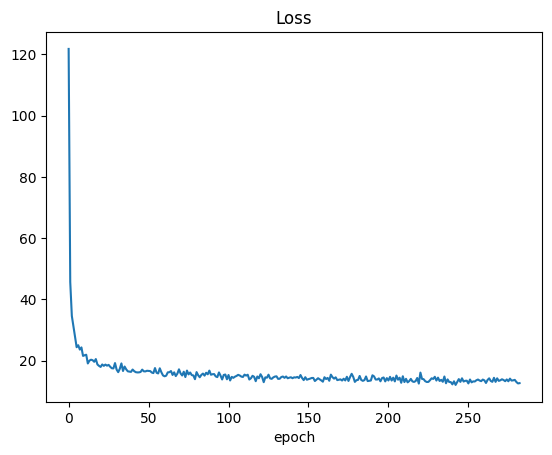

In [ ]:
# Load the checkpoint
if Config.load_from_checkpoint:
    checkpoint = torch.load(os.path.join("models", Config.model_name, f"checkpoint-283.pt"))
else:
    checkpoint = None
# Initialize dataloader
#dataloader = get_dataloader(Config.data_dir, Config.batch_size, Config.image_size)

# Train model
#torch.cuda.empty_cache()
generate(5,checkpoint)

In [ ]:
loss_history

[121.73951390571892, 45.6546653136611, 34.57699124561623, 31.209921673173085, 27.938401249004528, 24.38620451861061, 25.028956476598978, 23.61146833456587, 24.32079608354252, 21.543586006737314, 21.7641166979447, 21.931103120208718, 19.081407530698925, 19.993319209315814, 20.31327732320642, 20.142278251296375, 19.619948950246908, 20.51357296592323, 18.757258703408297, 18.293037665251177, 17.949309330782853, 18.754983627295587, 18.301713526365347, 18.71181071968749, 18.369994950771797, 18.618150796275586, 18.004600616928656, 17.5116432774812, 17.47031346912263, 19.205943565815687, 17.086244535865262, 16.240135607949924, 17.34561231418047, 19.09500298538478, 16.623791302728932, 18.074378351680934, 17.157633344759233, 16.513547774171457, 16.442874098662287, 16.336628913733875, 17.101083355548326, 16.569878224661807, 16.233949058223516, 16.154158741876017, 16.175276545633096, 16.307468953629723, 17.078179440635722, 16.512719035177724, 16.49058652910753, 16.69709810972563, 16.63253516179975

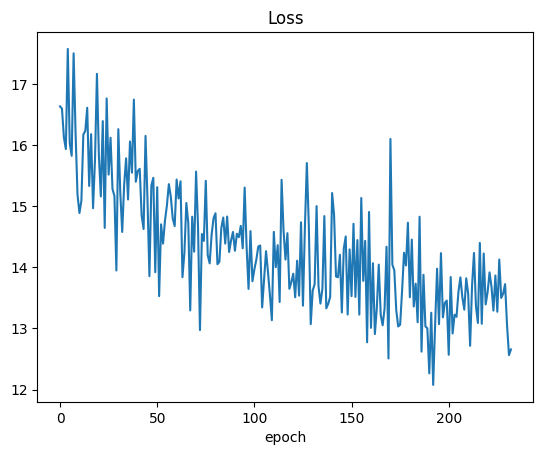

In [ ]:
criterion = nn.MSELoss()
diffusion = Diffusion(device=Config.device)
model = UNet().to(Config.device)
optimizer = optim.AdamW(model.parameters(), lr=Config.learn_rate)
    # Initialize parameters for training from last checkpoint
start_epoch, loss_history = load_checkpoint(checkpoint, model, optimizer, diffusion)
print(loss_history)
plt.plot(loss_history[50:])
plt.title('Loss')
plt.xlabel('epoch')
plt.savefig('loss')

[121.73951390571892, 45.6546653136611, 34.57699124561623, 31.209921673173085, 27.938401249004528, 24.38620451861061, 25.028956476598978, 23.61146833456587, 24.32079608354252, 21.543586006737314, 21.7641166979447, 21.931103120208718, 19.081407530698925, 19.993319209315814, 20.31327732320642, 20.142278251296375, 19.619948950246908, 20.51357296592323, 18.757258703408297, 18.293037665251177, 17.949309330782853, 18.754983627295587, 18.301713526365347, 18.71181071968749, 18.369994950771797, 18.618150796275586, 18.004600616928656, 17.5116432774812, 17.47031346912263, 19.205943565815687, 17.086244535865262, 16.240135607949924, 17.34561231418047, 19.09500298538478, 16.623791302728932, 18.074378351680934, 17.157633344759233, 16.513547774171457, 16.442874098662287, 16.336628913733875, 17.101083355548326, 16.569878224661807, 16.233949058223516, 16.154158741876017, 16.175276545633096, 16.307468953629723, 17.078179440635722, 16.512719035177724, 16.49058652910753, 16.69709810972563, 16.63253516179975

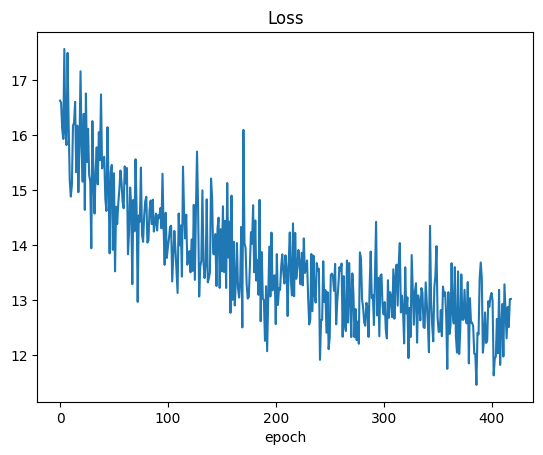

In [ ]:
checkpoint = torch.load(os.path.join("models", Config.model_name, f"checkpoint.pt"))
criterion = nn.MSELoss()
diffusion = Diffusion(device=Config.device)
model = UNet().to(Config.device)
optimizer = optim.AdamW(model.parameters(), lr=Config.learn_rate)
    # Initialize parameters for training from last checkpoint
start_epoch, loss_history = load_checkpoint(checkpoint, model, optimizer, diffusion)
print(loss_history)
plt.plot(loss_history[50:])
plt.title('Loss')
plt.xlabel('epoch')
plt.savefig('loss')